In [7]:
import numpy as np

In [8]:
from scipy.io import netcdf_file
import os
# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
#dataset = 'data10102019'
dataset = "01052014"
f = netcdf_file(os.path.join(os.path.abspath('') ,f"{dataset}.nc"))
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_u = f.variables['ugos'].data.squeeze()
vel_v = f.variables['vgos'].data.squeeze()


# fill in missing values
from common_functions import interpolate_missing_point

#imputed_vel_u = interpolate_missing_point(vel_u, np.ma.masked_invalid(vel_u).mask)
#imputed_vel_v = interpolate_missing_point(vel_v, np.ma.masked_invalid(vel_v).mask)
imputed_vel_u = np.nan_to_num(vel_u, nan=1e30)
imputed_vel_v = np.nan_to_num(vel_v, nan=1e30)

In [9]:
f.variables['time'].data

array([23496.], dtype=float32)

## Method Parameters:

In [10]:
a = 3
b = 2

In [11]:
from skimage.feature import peak_local_max

def vector_geom(a,b):
    vel_magnitude = np.hypot(imputed_vel_u, imputed_vel_v)

    satifies_crit_3 = peak_local_max(-vel_magnitude, min_distance=b)
    
    satifies_crit_1 = []
    direction = []

    for i,j in satifies_crit_3:
        center = imputed_vel_v[i,j]
        try:
            left = imputed_vel_v[i,j-a]
            right = imputed_vel_v[i,j+a]
        except IndexError:
            continue # point too close to the edge
        if abs(center) < abs(right) and abs(center) < abs(left) and np.sign(left)*np.sign(right) == -1:
            satifies_crit_1.append((i,j))
            direction.append(np.sign(left))
    
    satifies_crit_2 = []

    for (i, j), clockwise in zip(satifies_crit_1, direction):
        center = imputed_vel_u[i,j]
        try:
            bottom = imputed_vel_u[i-a, j]
            top = imputed_vel_u[i+a,j]
        except IndexError:
            continue # point to close to the edge
        if abs(center) < abs(bottom) and abs(center) < abs(top) and np.sign(bottom)*np.sign(top) == -1 and clockwise == np.sign(top):
            satifies_crit_2.append((i,j))
    
    eddies = np.asarray(satifies_crit_2)
    return np.column_stack([lat[eddies[:,0]], long[eddies[:,1]]])


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd

real_data = pd.read_csv("validation_data/01052014.csv")
real_data = real_data[["Lat","Lon"]].to_numpy()
real_data = real_data[(real_data[:,1] > -30) & (real_data[:,1] < -20) & (real_data[:,0] > 20) & (real_data[:,0] < 60)]

from dataclasses import dataclass

from scipy.spatial import KDTree
from sklearn.metrics.pairwise import haversine_distances

@dataclass
class Method:
    name: str
    points: np.ndarray
    P: int = 0
    TP: int = 0
    FP: int = 0
        
    def compare(self, ground_truth: np.ndarray, dist_tol):
        '''dist_tol is in km'''
        self.P = ground_truth.shape[0]
        
        tree_detected = KDTree(self.points)
        dist, index = tree_detected.query(ground_truth[:,0:2])
        truth = np.deg2rad(ground_truth[:,0:2])
        detected = np.deg2rad(self.points[index,:])
        dist_mat = haversine_distances(truth, detected)
        dist = np.diagonal(dist_mat) * 6371000/1000  # multiply by Earth radius to get kilometers
        
        self.TP = (dist < dist_tol).sum()
        self.mean_error = np.mean(dist[dist < dist_tol])
        self.FN = self.P - self.TP
        
        tree_truth = KDTree(ground_truth[:,0:2])
        dist, index = tree_truth.query(self.points)
        detected = np.deg2rad(ground_truth[index,0:2])
        dist_mat = haversine_distances(truth, detected)
        dist = np.diagonal(dist_mat) * 6371000/1000  # multiply by Earth radius to get kilometers
                
        self.FP = (dist > dist_tol).sum()
    
    @property
    def TPR(self):
        return self.TP/self.P
    
    @property
    def FDR(self):
        return self.FP/self.P
    
    @property
    def F1(self):
        return self.TP/(self.TP + 0.5*(self.FP + self.FN))

<IPython.core.display.Javascript object>


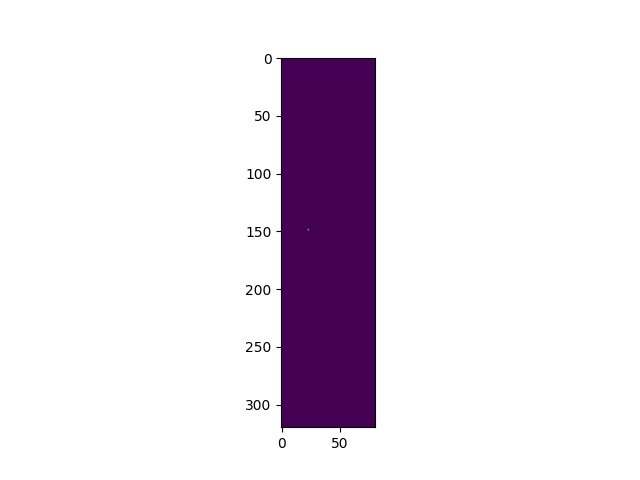

<IPython.core.display.Javascript object>


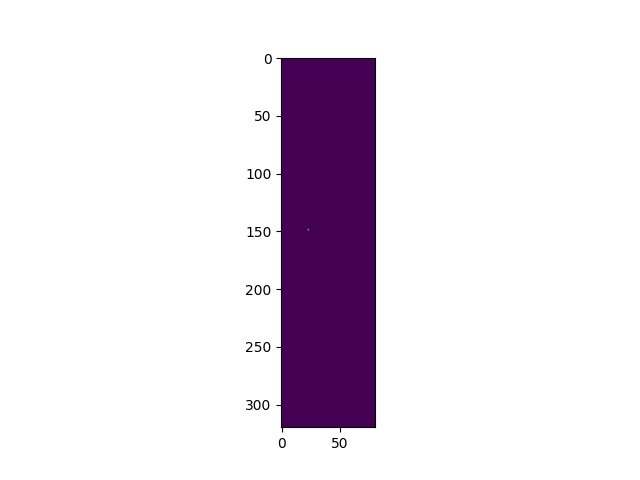

<IPython.core.display.Javascript object>


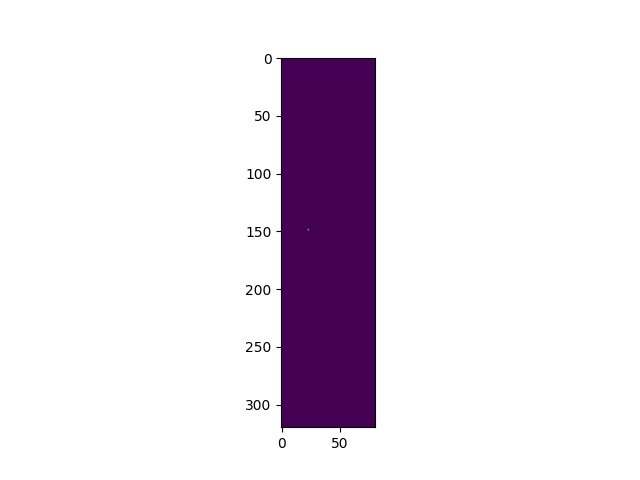

<IPython.core.display.Javascript object>


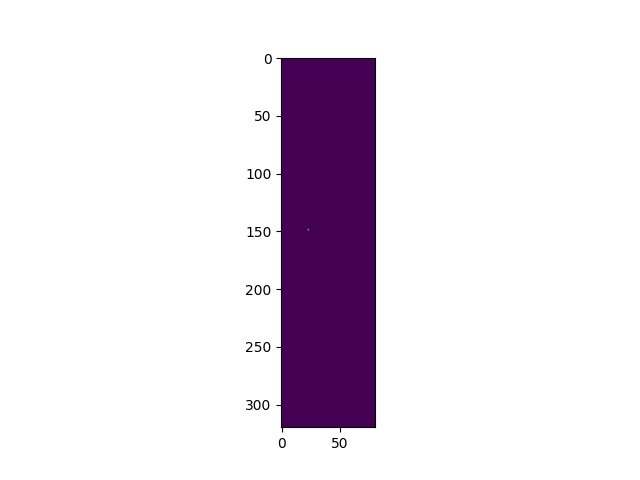

<IPython.core.display.Javascript object>


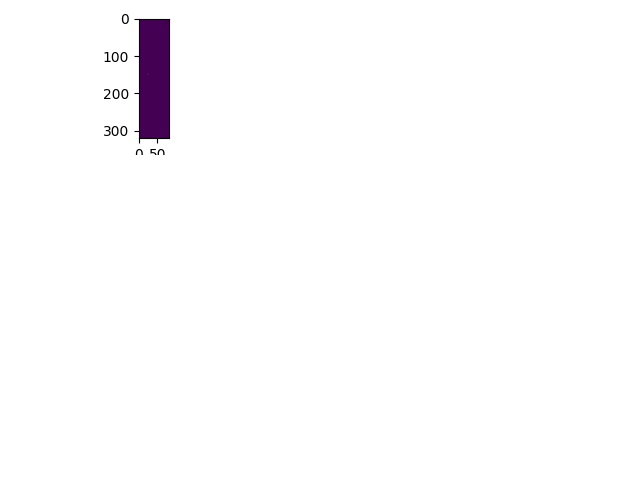

<IPython.core.display.Javascript object>


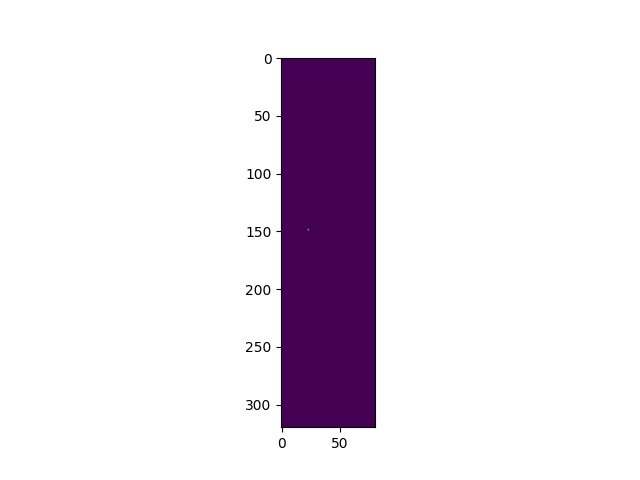

<IPython.core.display.Javascript object>


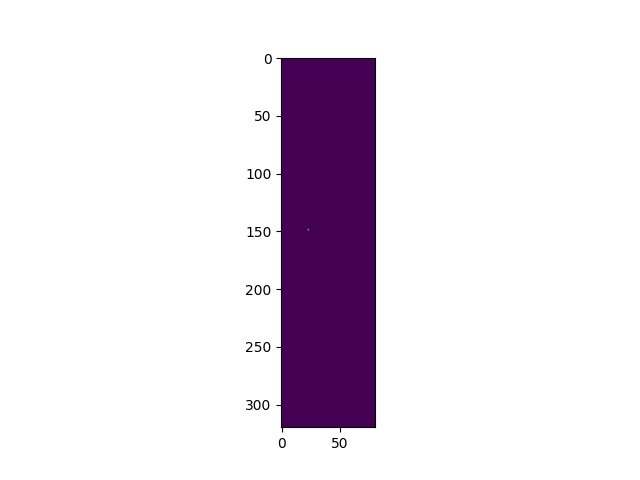

<IPython.core.display.Javascript object>


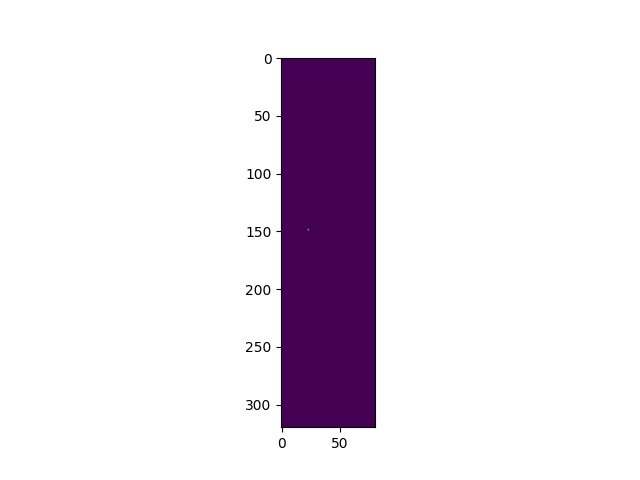

<IPython.core.display.Javascript object>


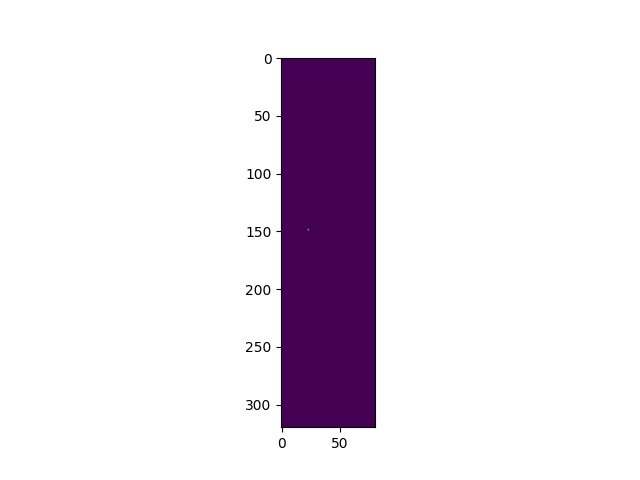

<IPython.core.display.Javascript object>


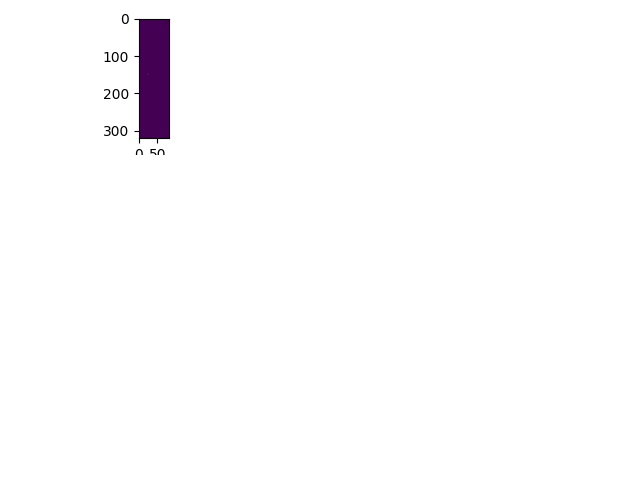

<IPython.core.display.Javascript object>


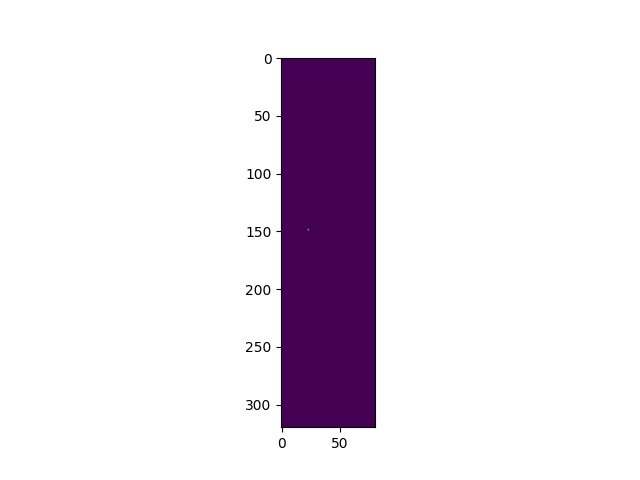

<IPython.core.display.Javascript object>


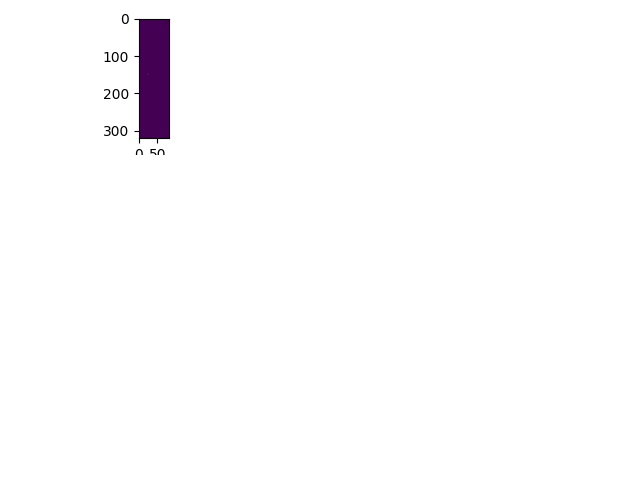

<IPython.core.display.Javascript object>


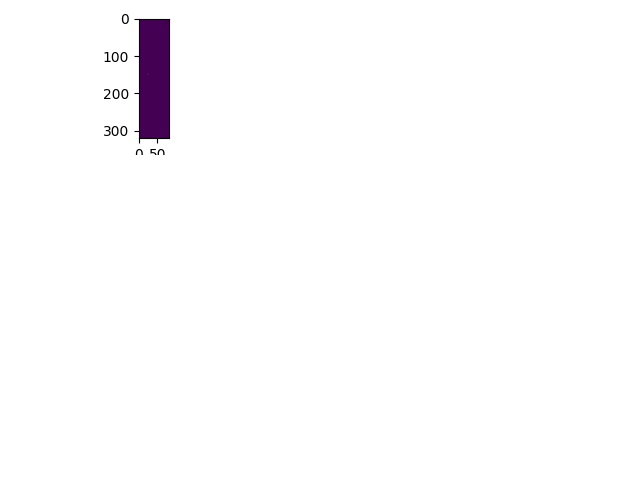

<IPython.core.display.Javascript object>


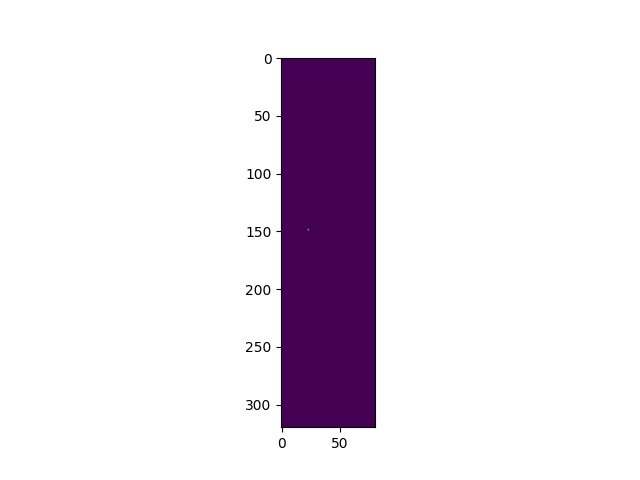

<IPython.core.display.Javascript object>


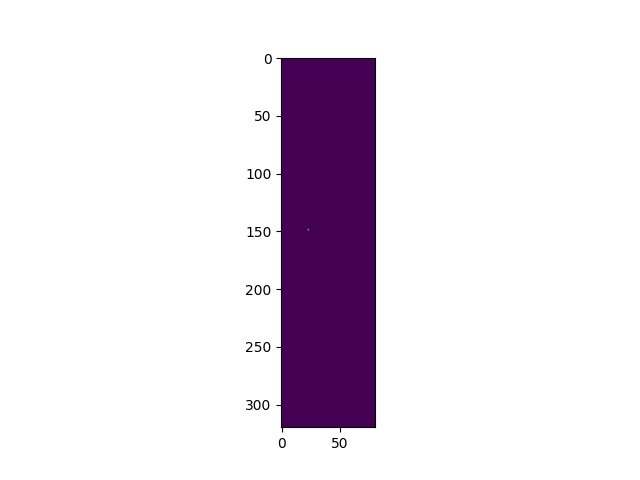

<IPython.core.display.Javascript object>


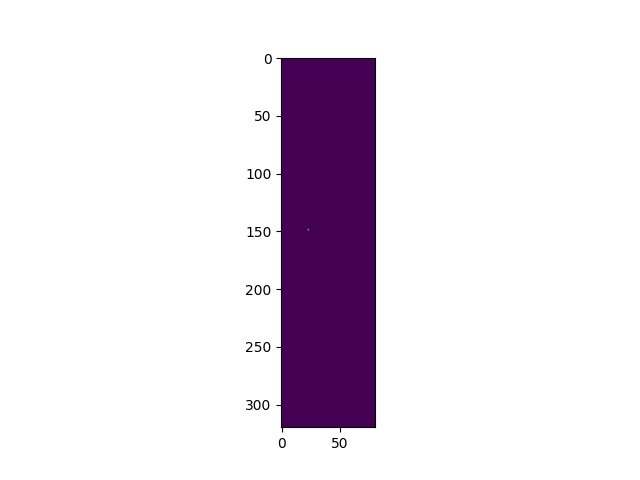

<IPython.core.display.Javascript object>


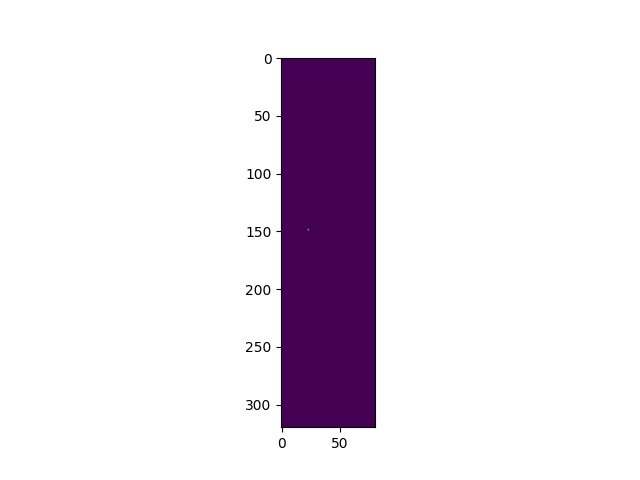

<IPython.core.display.Javascript object>


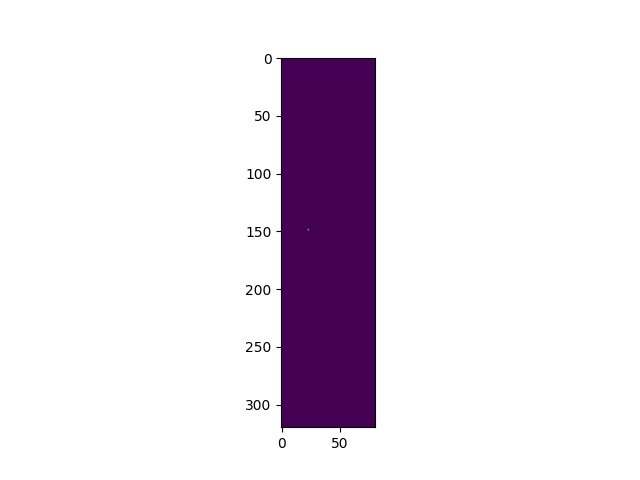

<IPython.core.display.Javascript object>


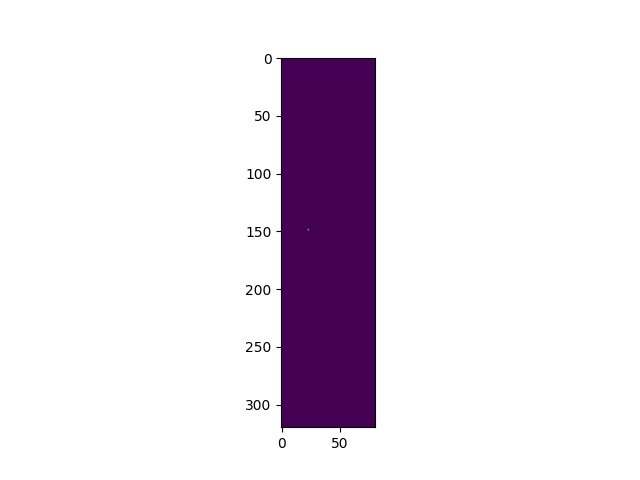

/tmp/ipykernel_1090820/3663035850.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<IPython.core.display.Javascript object>


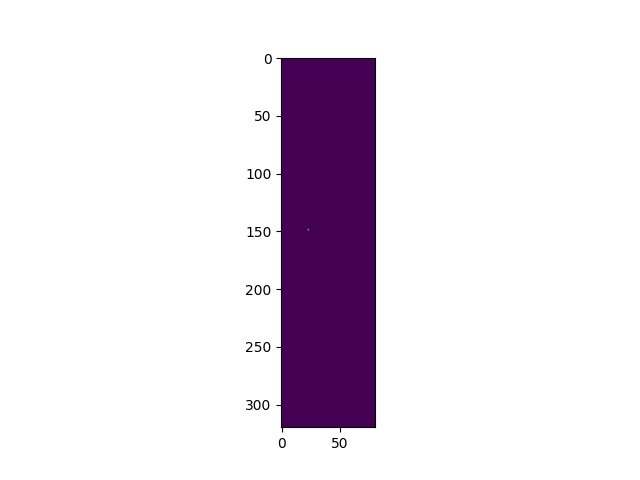

<IPython.core.display.Javascript object>


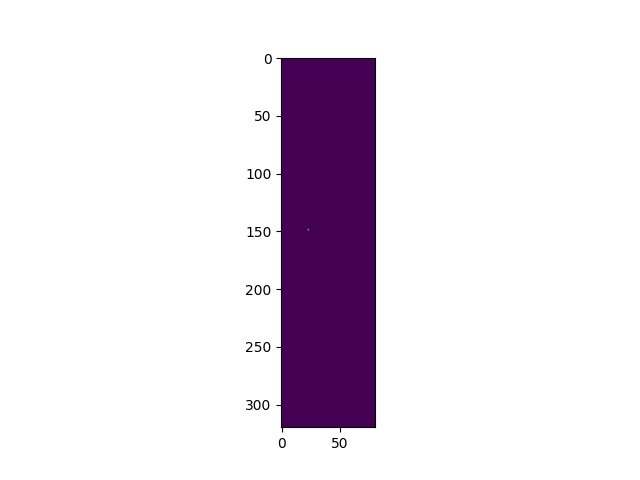

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


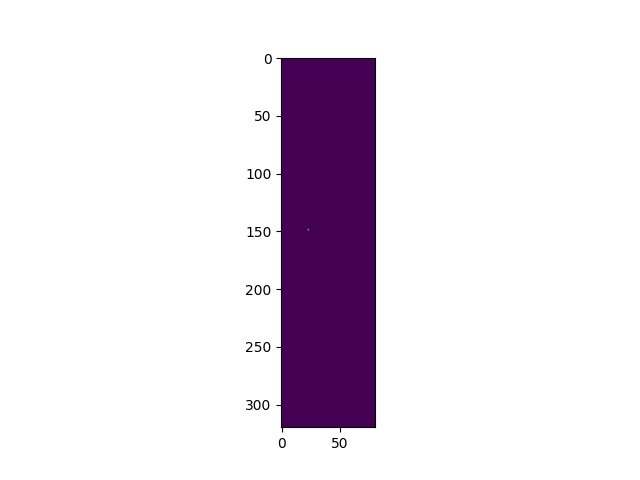

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


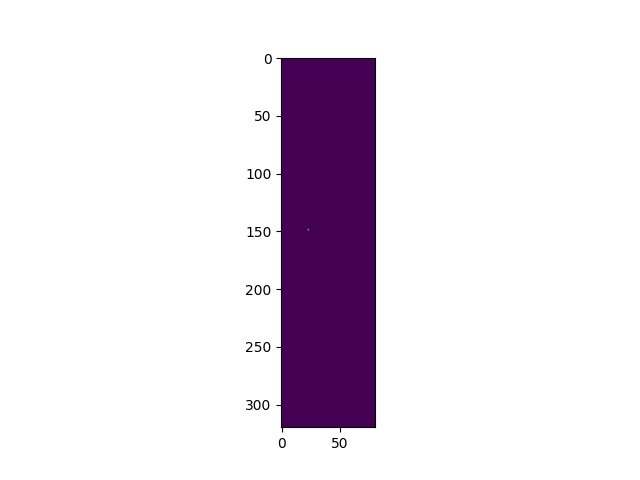

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


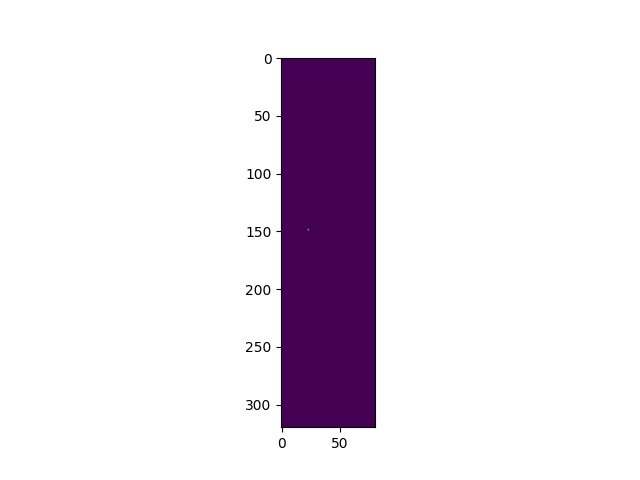

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


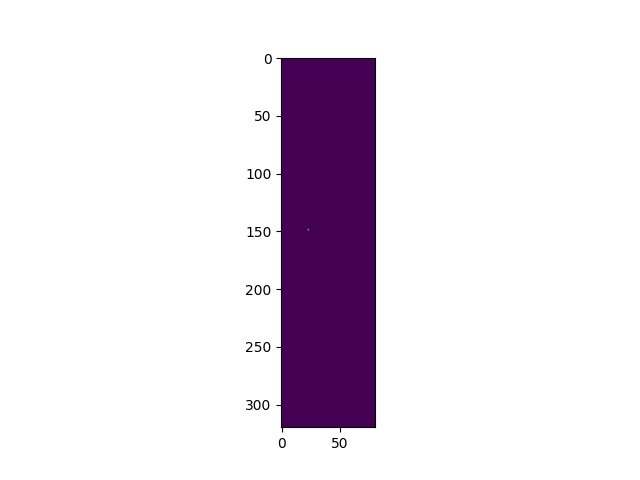

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


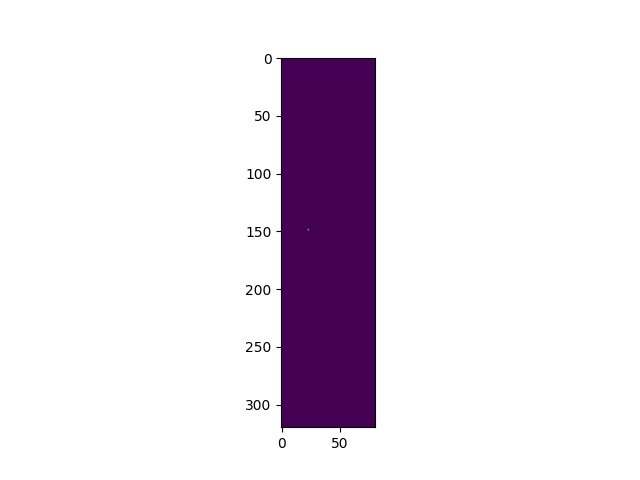

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


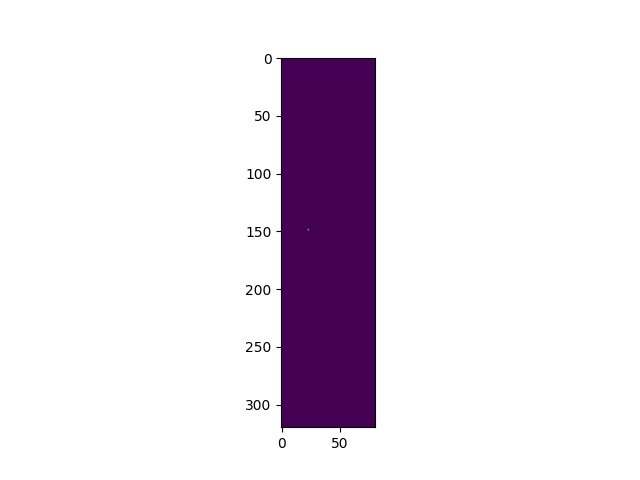

<IPython.core.display.Javascript object>


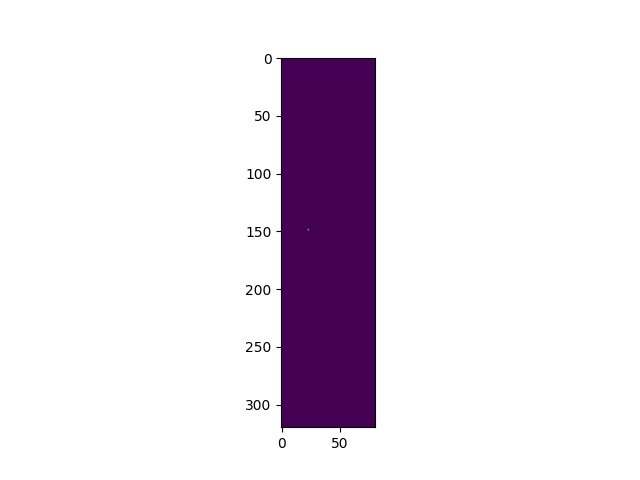

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


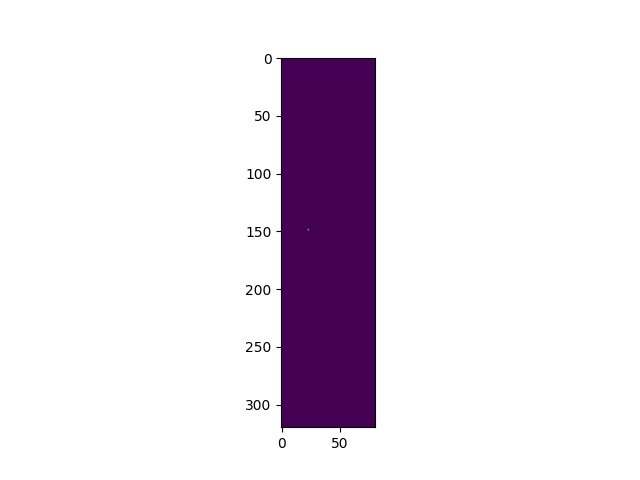

<IPython.core.display.Javascript object>


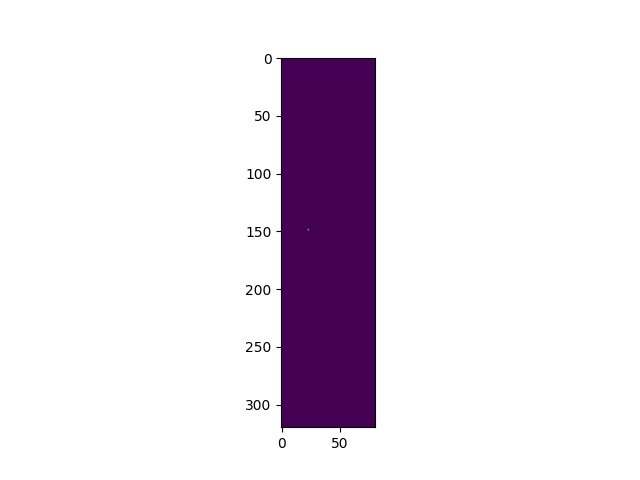

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


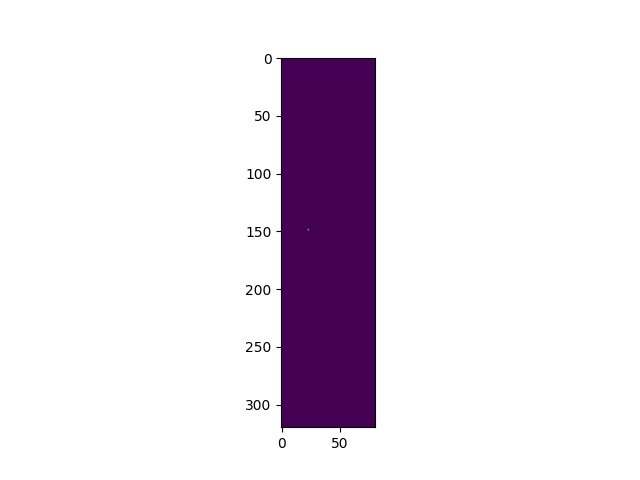

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


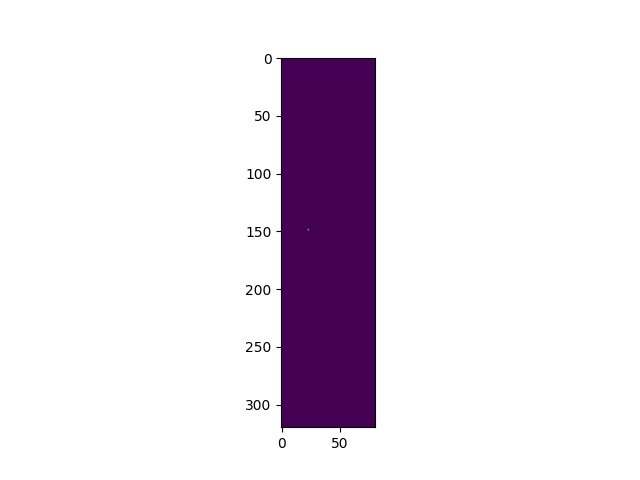

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


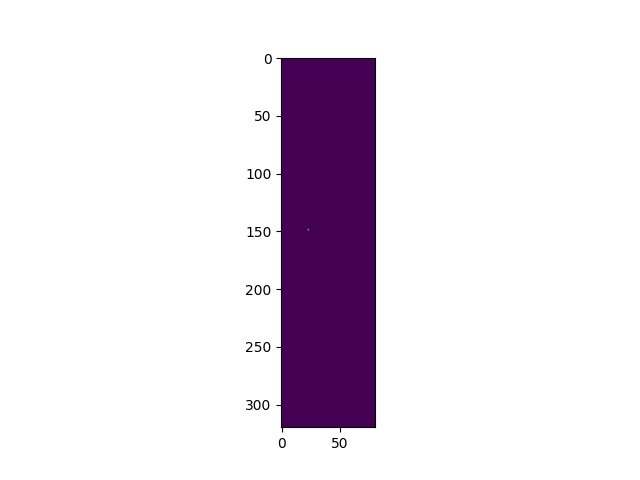

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


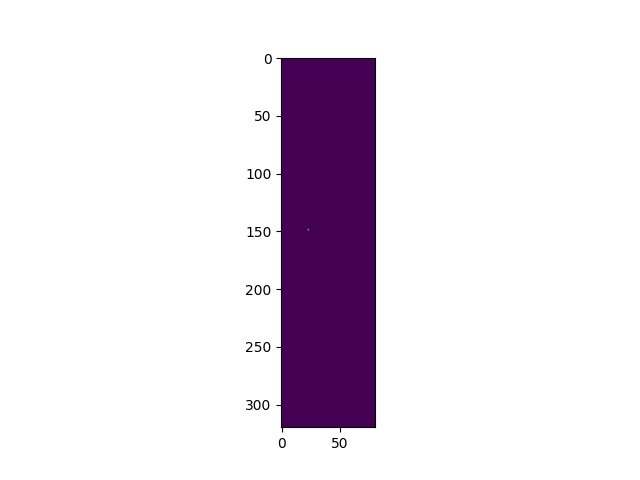

<IPython.core.display.Javascript object>


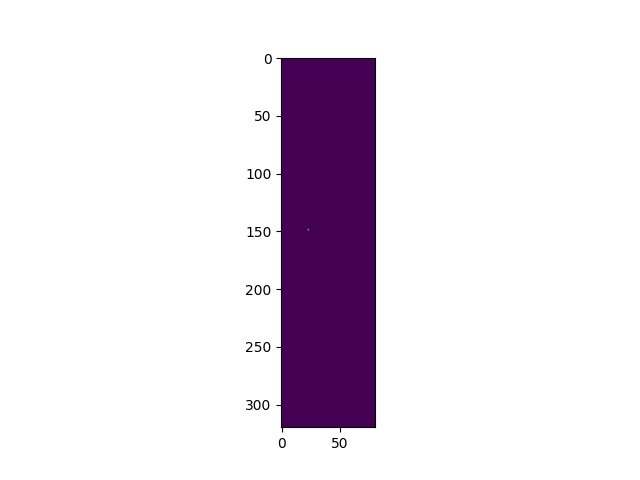

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


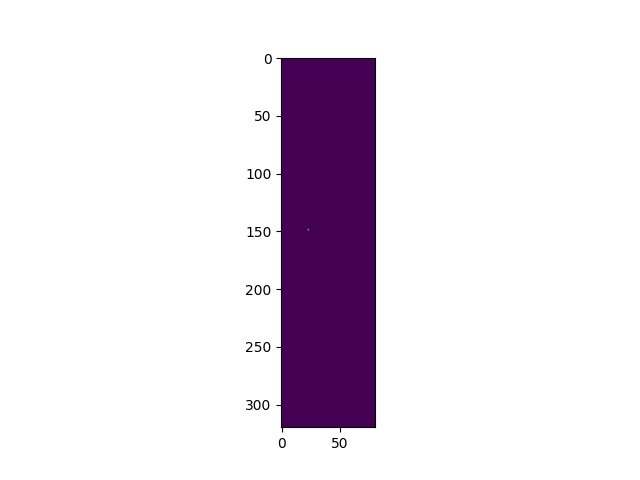

<IPython.core.display.Javascript object>


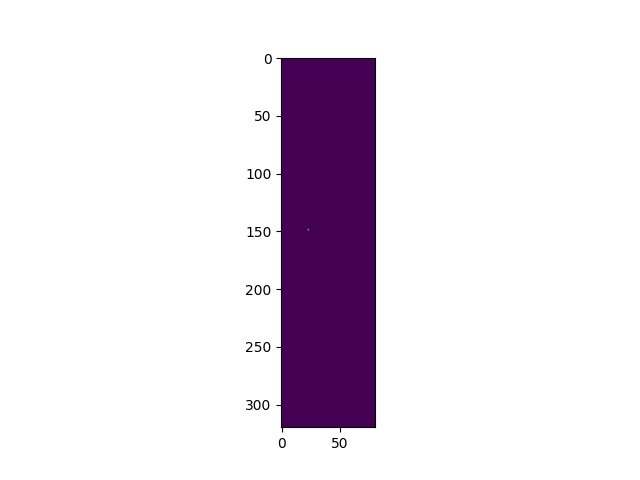

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


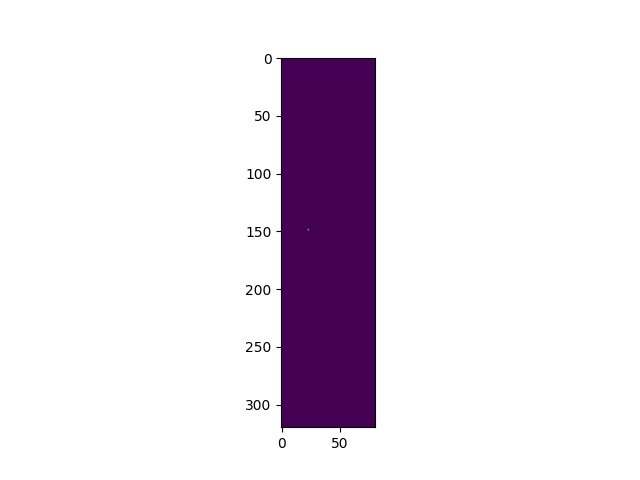

<IPython.core.display.Javascript object>


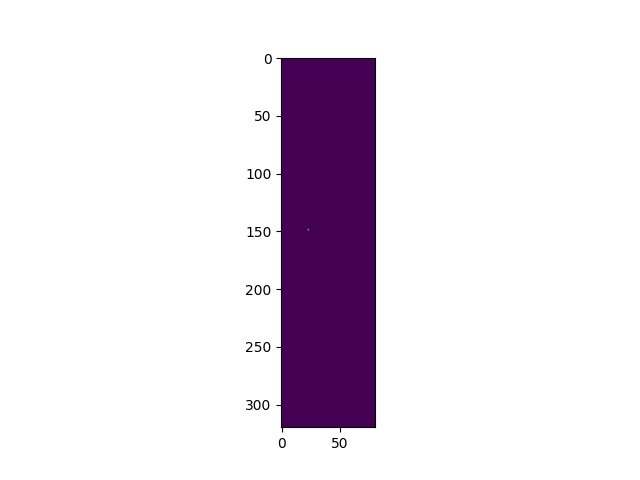

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


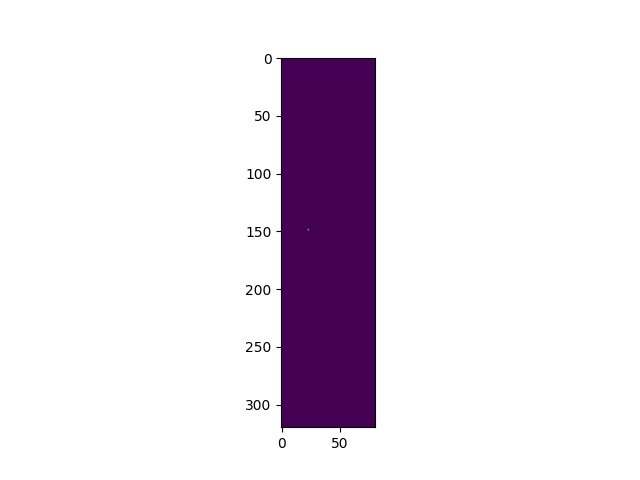

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


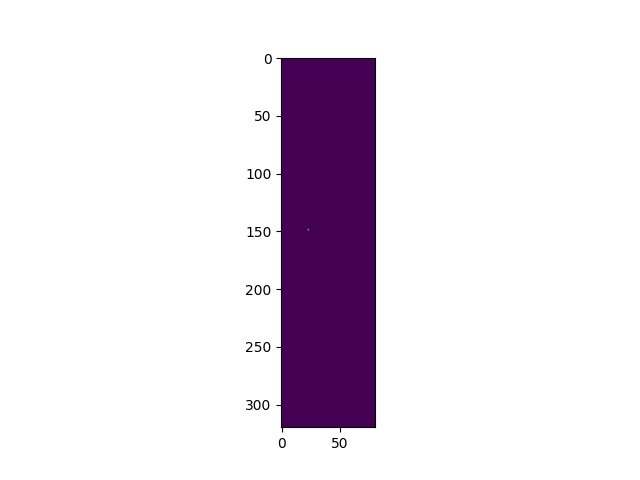

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


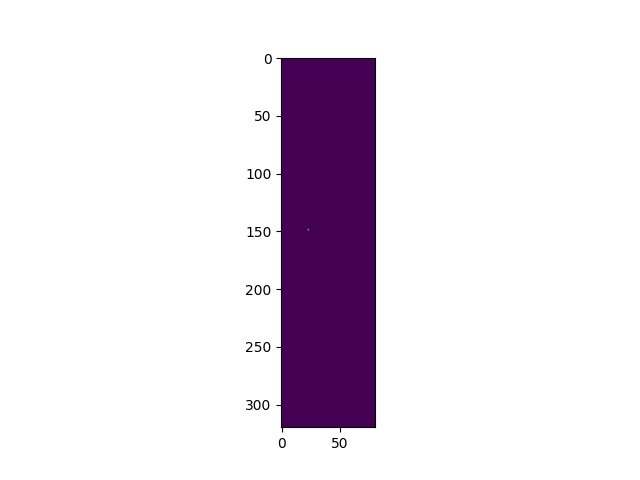

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


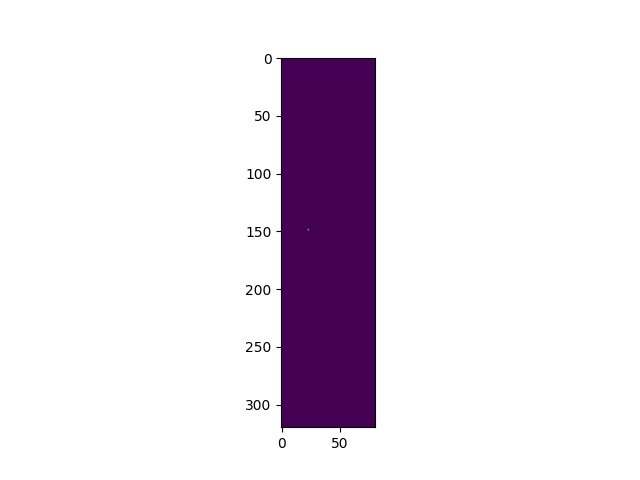

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


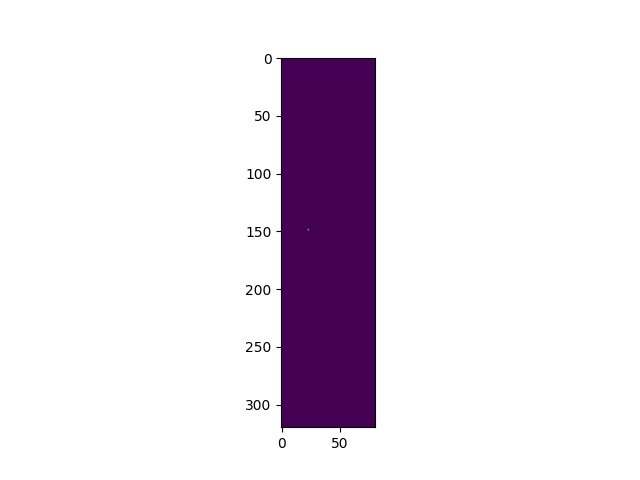

<IPython.core.display.Javascript object>


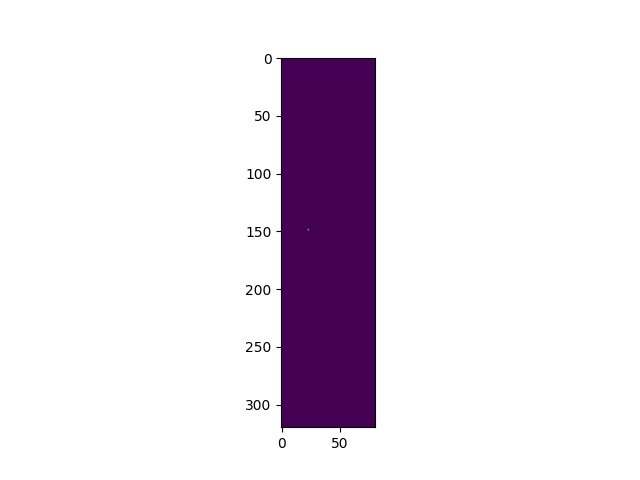

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


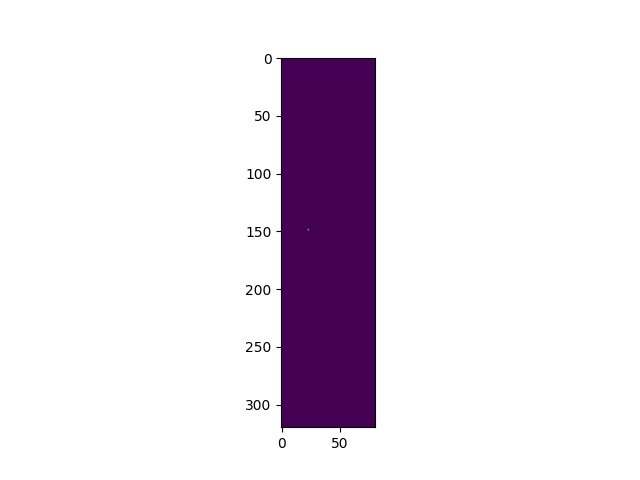

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


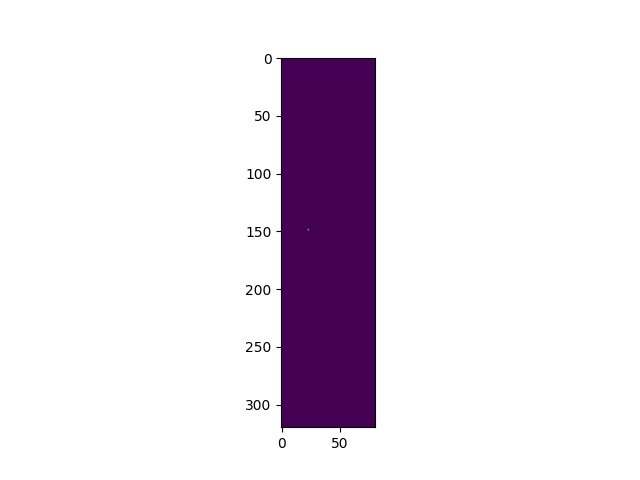

<IPython.core.display.Javascript object>


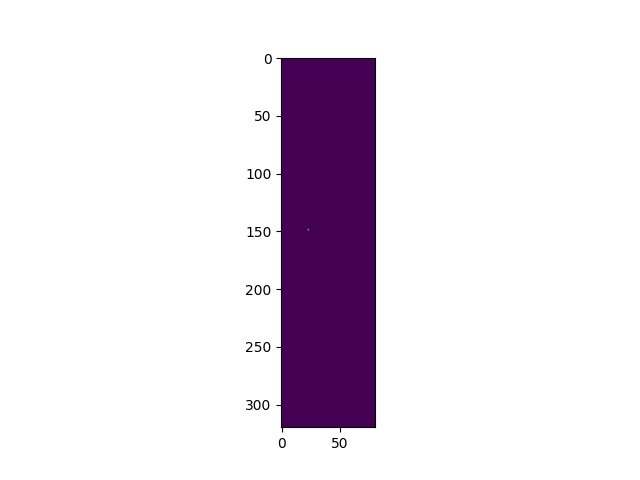

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


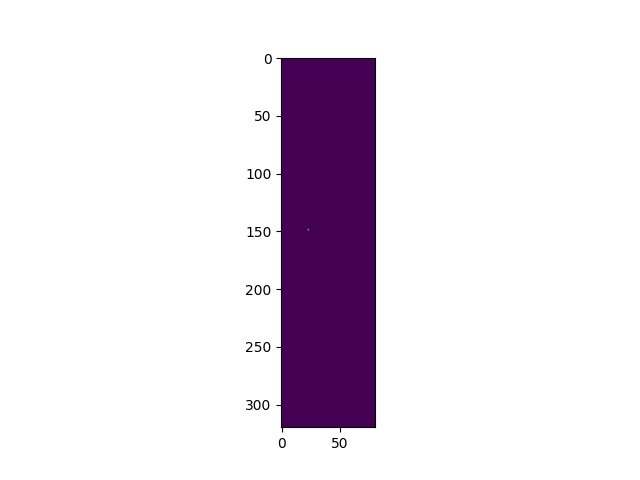

<IPython.core.display.Javascript object>


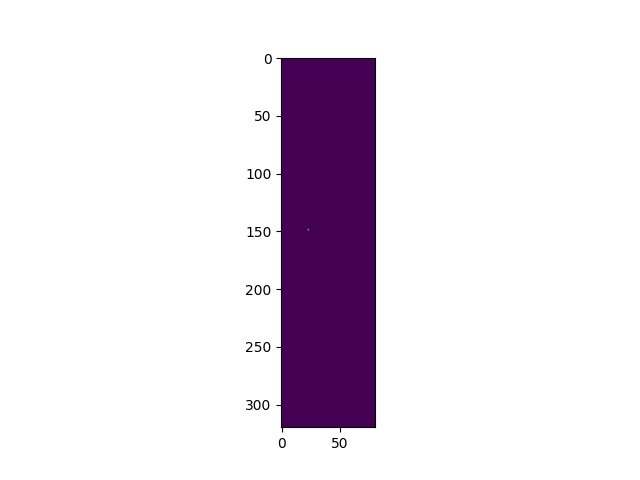

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
res = np.empty((10,10))
for a in range(10):
    for b in range(10):
        method = Method("",vector_geom(a+1,b+1))
        method.compare(real_data, 50)
        res[a,b] = method.F1

<IPython.core.display.Javascript object>


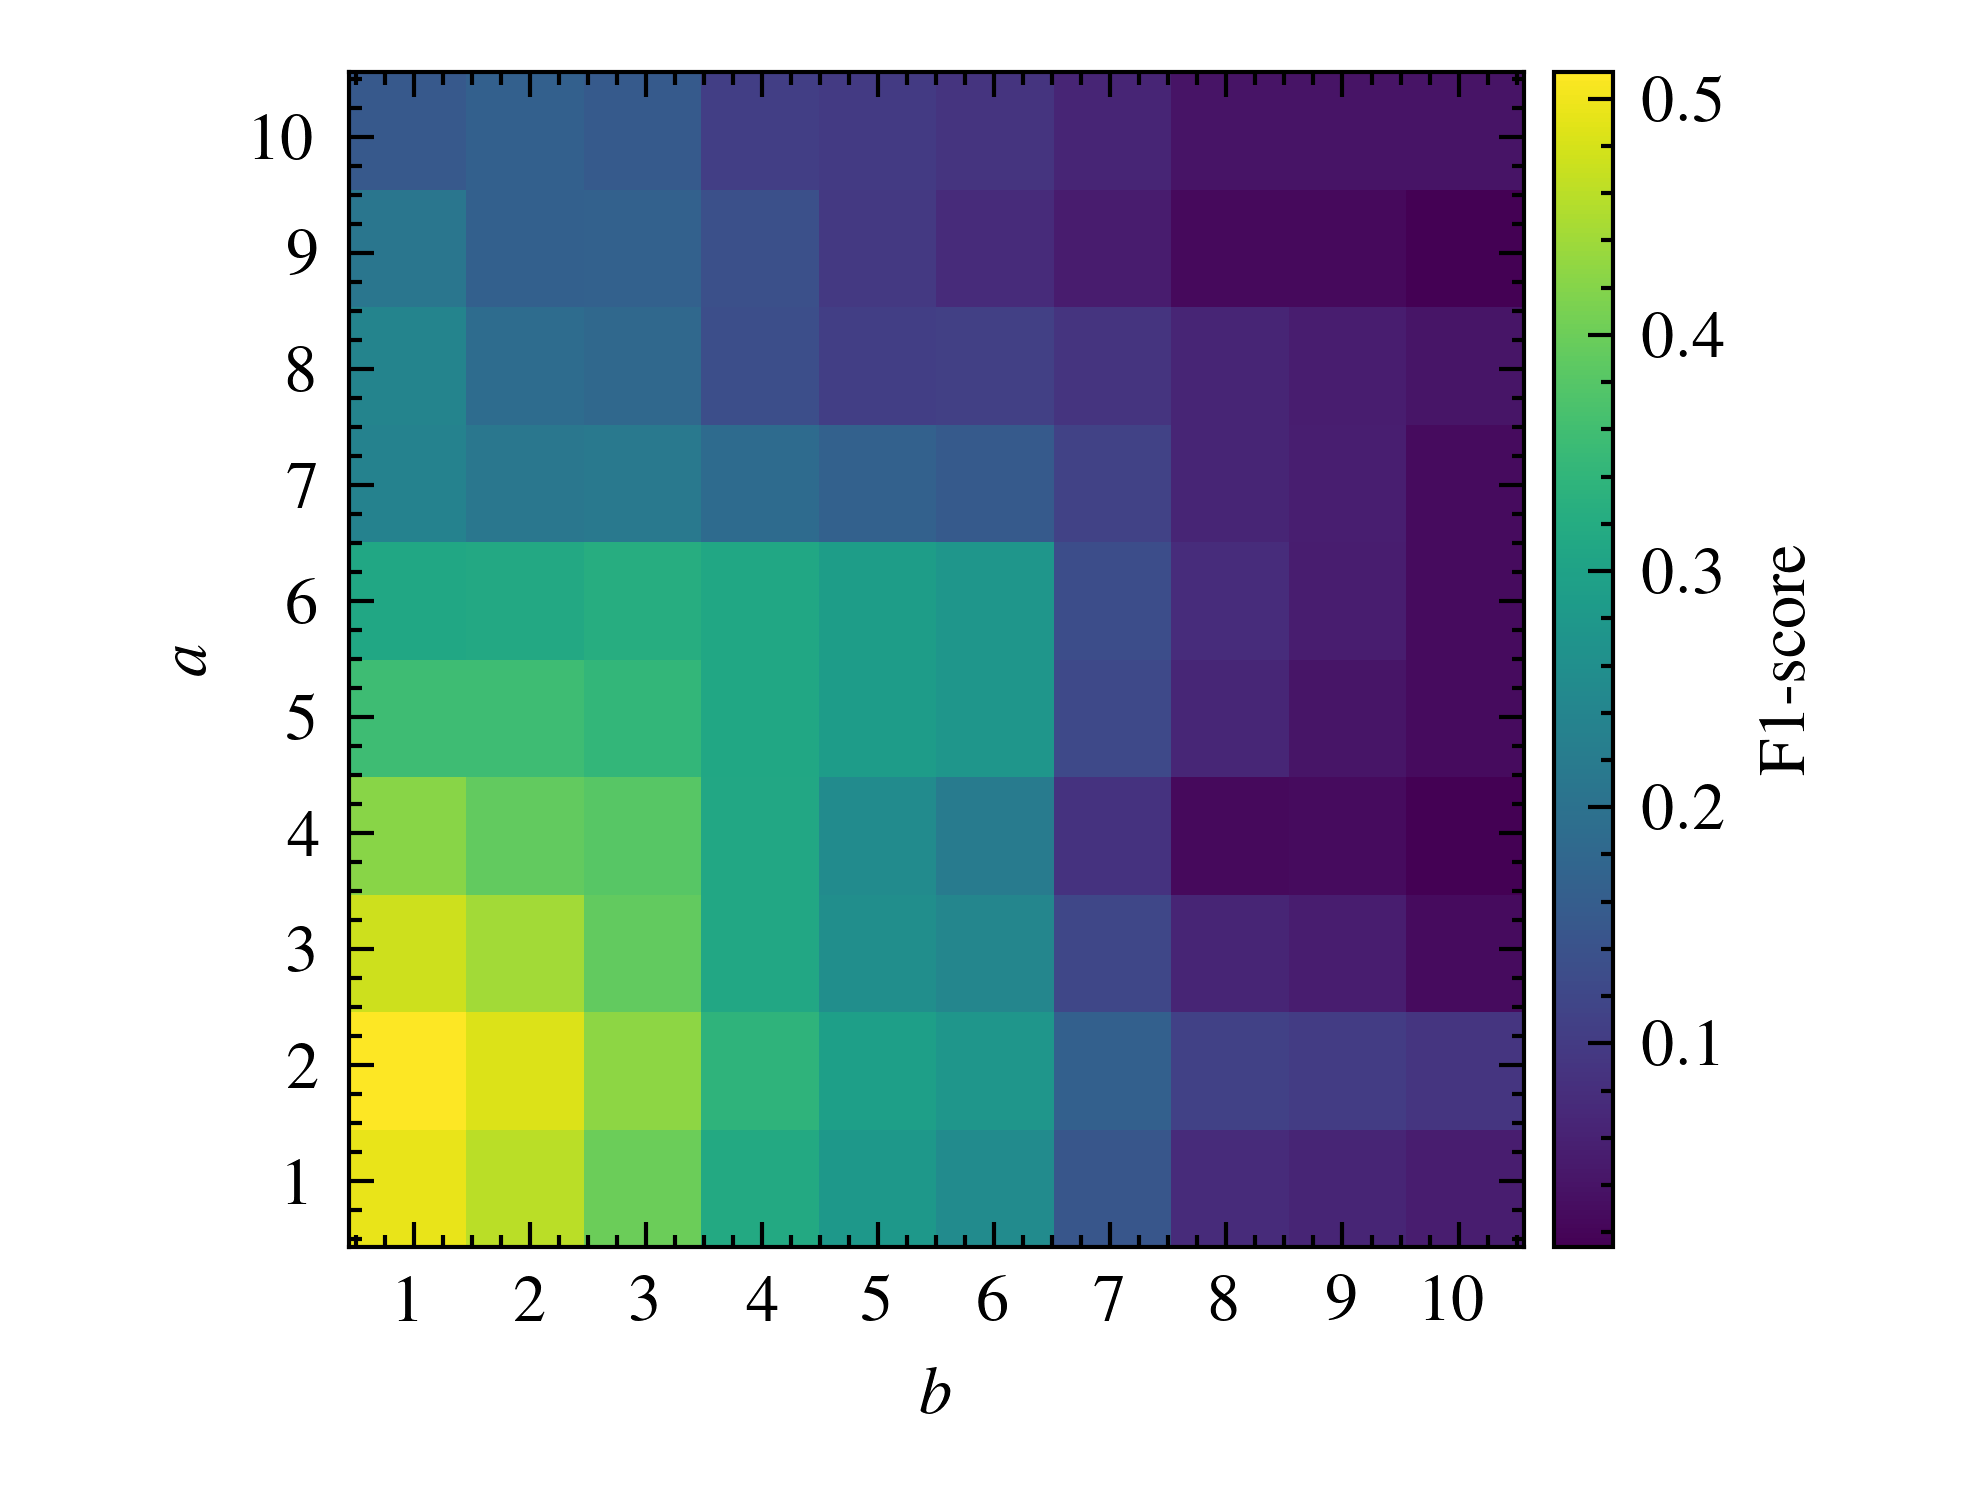

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use(['science','ieee'])
plt.figure()
im=plt.imshow(res, origin='lower', extent=[1,10,1,10], aspect='equal')
plt.ylabel("$a$")
plt.xlabel("$b$")
plt.xticks(np.linspace(1.5,9.5,10))
plt.yticks(np.linspace(1.5,9.5,10))
ax = plt.gca()
ax.set_xticklabels(range(1,11))
ax.set_yticklabels(range(1,11))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("F1-score")
plt.tight_layout()
plt.savefig("figures/params.pdf",bbox_inches='tight')